In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']

custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [2]:
# File containing the images
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati\Algol_1kHz_1_MMStack_Pos0.ome.tif")

immagini = tifffile.imread(file) 
# Select the specific image 
#imagenumber = 901

# Define a count per pixel threshold to find the speckles in the images
speckle_threshold=7000 #1100 #7000 #9500 #8000 #9000 #6500 #9000

# Plate scale arcseconds/pixels
plate_scale = 0.0376

# Diffraction limit of the telescope
aperture = 1.82                                                     # Aperture of the telescope (in meters)
wavelength = 700e-9                                                 # Reference wavelenght (in meters) 

diffraction_limit_radians = 2*1.22 * wavelength / aperture          # Diameter of the Airy disk
diffraction_limit_arcseconds = diffraction_limit_radians * 206265
print("Diffraction limit in arcseconds and pixels: ",diffraction_limit_arcseconds)

#Radius used to check for speckles (in pixels)
check_radius = int(diffraction_limit_arcseconds/plate_scale) #4 corrisponde al diametro del disco di airy in pixel
print ("Check radius in pixels: ", check_radius)



Diffraction limit in arcseconds and pixels:  0.19357176923076921
Check radius in pixels:  5


# Autocorrelation of the images

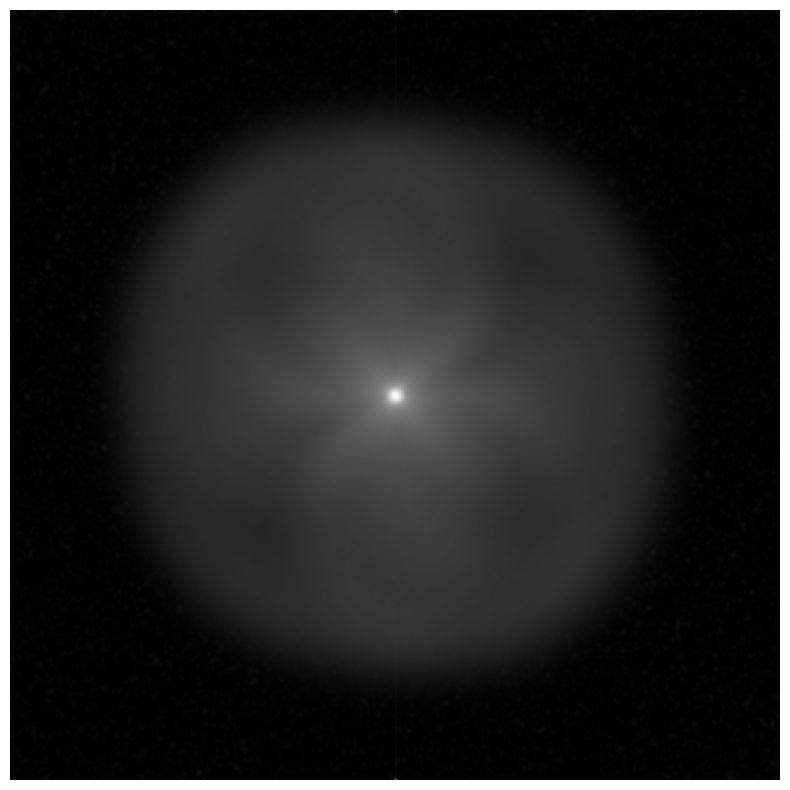

In [87]:
def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)


sum_ft = None

for i in range(4998):
    imagenumber = 0 + i 
    data = immagini[imagenumber]

    data_raw = data.copy()
    data_clean = data_raw.copy()
    background_level = np.median(data_raw)
    data = data_raw - background_level
    data[data < 0] = 0

    image = data.copy()
    if image.ndim == 3:
        image = image[:, :, :3].mean(axis=2) 
    elif image.ndim == 2:
        image = image  
    else:
        raise ValueError("Unexpected image dimensions: {}".format(image.shape))

    ft = calculate_2dft(image)
    

    if sum_ft is None:
        sum_ft = np.abs(ft)
    else:
        sum_ft += np.abs(ft)


plt.figure(figsize=(10, 10))
plt.set_cmap('gray')
plt.imshow(np.log(sum_ft))
plt.axis("off")
plt.title("")
plt.show()



In [ ]:

hdu = fits.PrimaryHDU(sum_ft)
hdul = fits.HDUList([hdu])
hdul.writeto('power_spectrum.fits', overwrite=True)

print("FITS file saved as 'power_spectrum.fits'")

In [70]:
# Compute the magnitude of the Fourier transform
magnitude = np.abs(ft)

#vedere che sia l'immagine ppulita dal background

# Generate frequency components for the Fourier transform
freqs_x = np.fft.fftfreq(ft.shape[1])
freqs_y = np.fft.fftfreq(ft.shape[0])
freqs_x, freqs_y = np.meshgrid(freqs_x, freqs_y)

max_idx = np.unravel_index(np.argmax(magnitude), magnitude.shape)

dominant_frequency = (freqs_x[max_idx], freqs_y[max_idx])

print("Dominant spatial frequency:", dominant_frequency)
if freqs_x[max_idx] != 0:
    wavelength_x = 1 / abs(freqs_x[max_idx])
else:
    wavelength_x = float('inf')  # No periodicity along x-axis

if freqs_y[max_idx] != 0:
    wavelength_y = 1 / abs(freqs_y[max_idx])
else:
    wavelength_y = float('inf')  # No periodicity along y-axis

print("Wavelength in pixels (x-axis):", wavelength_x)
print("Wavelength in pixels (y-axis):", wavelength_y)


Dominant spatial frequency: (np.float64(-0.5), np.float64(-0.5))
Wavelength in pixels (x-axis): 2.0
Wavelength in pixels (y-axis): 2.0


Peak index: 256


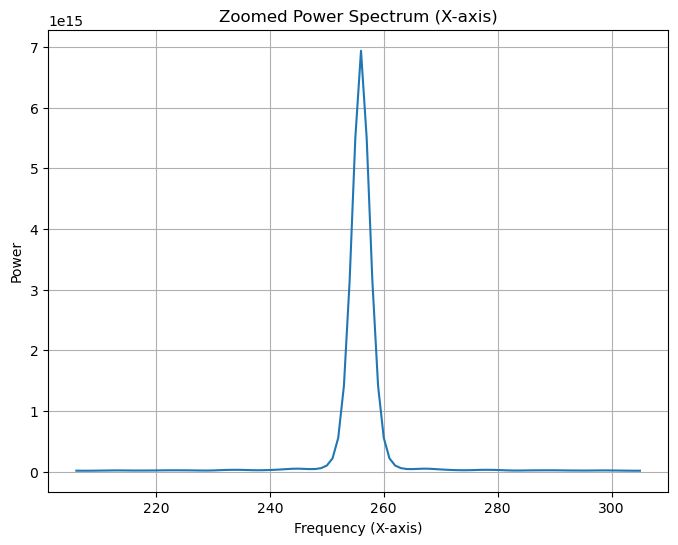

FWHM of the distribution: 3.9363057968812503


In [71]:
from scipy.optimize import curve_fit

power_spectrum = np.abs(ft) ** 2

power_spectrum_x = np.sum(power_spectrum, axis=0)
power_spectrum_y = np.sum(power_spectrum, axis=1)

peak_index = np.argmax(power_spectrum_x)
zoom_range = 50 
start_index = max(0, peak_index - zoom_range)
end_index = min(len(power_spectrum_x), peak_index + zoom_range)

print("Peak index:", peak_index)
plt.figure(figsize=(8, 6))
plt.plot(range(start_index, end_index), power_spectrum_x[start_index:end_index])
plt.title('Zoomed Power Spectrum (X-axis)')
plt.xlabel('Frequency (X-axis)')
plt.ylabel('Power')
plt.grid()
plt.show()


def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

x_values = np.arange(start_index, end_index)
y_values = power_spectrum_x[start_index:end_index]

popt, _ = curve_fit(gaussian, x_values, y_values, p0=[np.max(y_values), peak_index, 10])
a, x0, sigma = popt
fwhm = 2 * np.sqrt(2 * np.log(2)) * sigma
print("FWHM of the distribution:", fwhm)


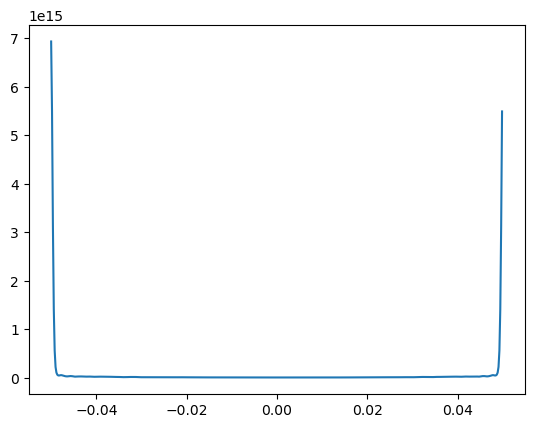

In [ ]:
from scipy.optimize import curve_fit
ft = calculate_2dft(image)
ps = np.abs(np.fft.fft(image))**2

time_step = 1 / 30
freqs = np.fft.fftfreq(data.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])


<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\buonc\AppData\Local\Temp\ipykernel_13160\310879640.py:3: SyntaxWarning: invalid escape sequence '\p'
  data = np.asarray(Image.open('immagini\prova_fft.png'))


Plotting 2d Fourier Transform ...


C:\Users\buonc\AppData\Local\Temp\ipykernel_13160\310879640.py:3: SyntaxWarning: invalid escape sequence '\p'
  data = np.asarray(Image.open('immagini\prova_fft.png'))


ValueError: x and y must have same first dimension, but have shapes (1127,) and (2002,)

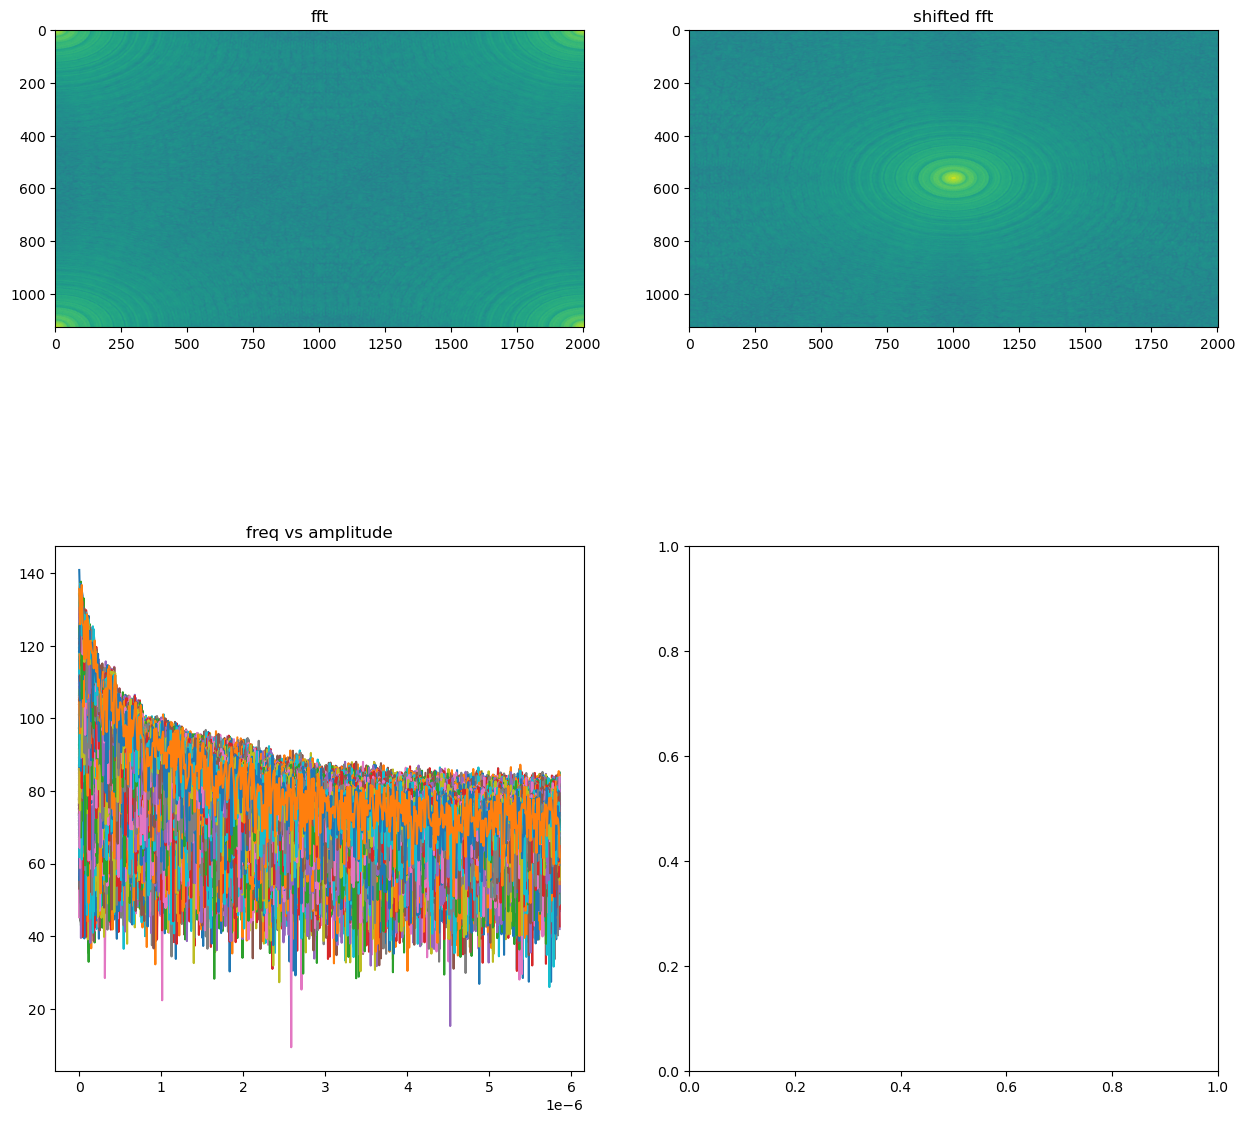

In [ ]:

from PIL import Image
from scipy import stats
#data = np.asarray(Image.open('immagini\prova_fft.png'))

y = np.arange(0,int(np.size(data,0)),1)
x = np.arange(0,int(np.size(data,1)),1)
z = data
npix = data.shape[0]

fourier_image = np.fft.fft2(data)
fourier_amplitudes = np.abs(fourier_image)**2

#physical distance between pixels
fs = 0.0132/npix
freq_shifted = fs/2 * np.linspace(-1,1,npix)
freq = fs/2 * np.linspace(0,1,int(npix/2))

print("Plotting 2d Fourier Transform ...")
fig, axs = plt.subplots(2,2,figsize=(15, 15))
axs[0,0].imshow(10*np.log10(np.abs(fourier_image)))
axs[0,0].set_title('fft')
axs[0,1].imshow(10*np.log10(np.abs(np.fft.fftshift(fourier_image))))
axs[0,1].set_title('shifted fft')
axs[1,0].plot(freq,10*np.log10(np.abs(fourier_amplitudes[:npix//2])))
axs[1,0].set_title('freq vs amplitude')
for ii in list(range(npix//2)):
    axs[1,1].plot(freq_shifted,10*np.log10(np.fft.fftshift(np.abs(fourier_amplitudes[ii]))))
axs[1,1].set_title('shifted freq vs amplitude')

#frequencies corresponding to signal PSD
kfreq = np.fft.fftfreq(npix) * npix
kfreq2D = np.meshgrid(kfreq, kfreq)

knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)
knrm = knrm.flatten()
fourier_amplitudes = fourier_amplitudes.flatten()

#power spectrum
kbins = np.arange(0.5, npix//2+1, 1.)
kvals = 0.5 * (kbins[1:] + kbins[:-1])

Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                     statistic = "mean",
                                     bins = kbins)
Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

max_power = np.max(Abins)
max_power_index = np.argmax(Abins)
x_correspondent_value = fs / kvals[max_power_index]

fig = plt.figure(figsize=(10, 10))
plt.loglog(fs/kvals, Abins)
plt.axvline(x=fs / kvals[max_power_index], color='r', linestyle='--', label='Max Power')
plt.xlabel("Spatial Frequency $k$ ")#[meters]")
plt.ylabel("Power per Spatial Frequency $P(k)$")
plt.legend()
plt.tight_layout()


print("Maximum value of the power spectrum:", max_power)
print("X correspondent value:", x_correspondent_value)

In [ ]:
# Pixel size in meters
pixel_size = 6.8e-6
wavele = 2*np.pi/x_correspondent_value


Wavelength in pixels: 8.765625e-11
